In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
sys.path.append("../utility")
sys.path.append("../train")
from Utility import data_collecter
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
            "DKNGU",
                ]
Method_names = ["KDerivative","KRBF",\
            "KDNN","KRNN","DKUC",\
            "DKAC","DKN", "MC-DKN(ours)"
                ]
suffixes =["4_28", "4_30", "5_2", "5_2", "5_2", "5_2_ode_constraint"]

In [7]:
def eval_err(suffix,env_name,method_index):
    # method_index = 0
    method = Methods[method_index]
    root_path = "../Data/"+suffix
    print(method)
    if method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KoopmanNonlinear"):
        import Learn_KoopmanNonlinear_with_KlinearEig as lka
    elif method.endswith("KoopmanNonlinearA"):
        import Learn_KoopmanNonlinearA_with_KlinearEig as lka
    elif method.endswith("KoopmanU"):
        import Learn_Koopman_with_KlinearEig as lka
    elif method.endswith("KoopmanAE"):
        import Learn_KoopmanAE_with_KlinearEig as lka
    elif method.endswith("DKNGU"):
        import Learn_DKN_gxu1 as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name) and file.endswith("samples20000.pth"):
            model_path = file  
    if method.endswith("DKNGU"):
        for file in os.listdir(root_path):
            if file.startswith(method+"_"+env_name) and file.endswith("bdim1_samples20000_geom0.1_ta.pth"):
                model_path = file
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = 3
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim, device="cpu")
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1, device="cpu")
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim, device="cpu")
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim, device="cpu")  
    elif method.endswith("KoopmanAE"):
        layer = dicts["layer"]
        dlayer = dicts["dlayer"]
        NKoopman = layer[-1]
        net = lka.Network(layer,dlayer,NKoopman,udim, device="cpu")  
    elif method.endswith("DKNGU"):
        state_encode_layers = dicts["Statelayer"]
        control_encode_layers = dicts["Controllayer"]
        # Nkoopman1 = control_encode_layers[0] - udim
        Nkoopman1 = control_encode_layers[0]
        # Nkoopman1 = 22
        # control_output_dim = control_encode_layers[-1] + control_encode_layers[0]
        control_output_dim = control_encode_layers[-1]
        net = lka.Network(state_encode_layers, control_encode_layers, Nkoopman1, udim, control_output_dim, device="cpu")

    net.load_state_dict(state_dict)
    device = torch.device("cpu")
    # net.cuda()
    net.double()
    net.to(device)
    Samples = 5000
    steps = 30
    random.seed(2022)
    np.random.seed(2022)
    times = 4 
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    with torch.no_grad():
        for i in range(times):
            test_data_path = "../Data/{}{}.npy".format(env_name,i)
            if os.path.exists(test_data_path):
                test_data = np.load("../Data/{}{}.npy".format(env_name,i))
            else:
                test_data = Data_collect.collect_koopman_data(Samples,steps)
                np.save("../Data/{}{}.npy".format(env_name,i),test_data)
            max_loss,mean_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    np.save("../Prediction_Results/Compare/"+env_name+"_"+method+"embed.npy",np.array([max_mean,max_std,mean_mean,mean_std]))
    # np.save("../Prediction_Results/Compare/"+env_name+"_"+"KoopmanNonlinearA"+"embed.npy",np.array([max_mean,max_std,mean_mean,mean_std]))
    return max_mean,max_std,mean_mean,mean_std

In [10]:
# env_name = "DampingPendulum"
# env_name = "CartPole-v1"
# env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "TwoLinkRobot"
# env_names = ["DampingPendulum","CartPole-v1","MountainCarContinuous-v0","Pendulum-v1","Franka","TwoLinkRobot"]
env_names = ["DampingPendulum","CartPole-v1","MountainCarContinuous-v0","Pendulum-v1","DoublePendulum","LunarLanderContinuous-v2"]
for env in ["CartPole-v1"]:
    for i in [2,3,4,5,6,7]: 
    # for i in [2]:
            eval_err(suffixes[i-2],env,method_index=i)

KNonlinear
KNonlinearRNN


/tmp/ipykernel_1704037/3957604264.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))


KoopmanU
KoopmanNonlinearA
KoopmanNonlinear
DKNGU


In [ ]:
# suffix = "Reacher2_9"
# env_name = "Reacher-v2"
# for i in range(5):
#     eval_err(suffix,env_name,method_index=i+2)

In [ ]:
# #Franka
# def eval_err(suffix,env_name,method_index):
#     # method_index = 0
#     method = Methods[method_index]
#     root_path = "../Data/"+suffix
#     print(method)
#     if method.endswith("KNonlinear"):
#         import Learn_Knonlinear as lka
#     elif method.endswith("KNonlinearRNN"):
#         import Learn_Knonlinear_RNN as lka
#     elif method.endswith("KoopmanNonlinear"):
#         import Learn_KoopmanNonlinear_with_KlinearEig as lka
#     elif method.endswith("KoopmanNonlinearA"):
#         import Learn_KoopmanNonlinearA_with_KlinearEig as lka
#     elif method.endswith("KoopmanU"):
#         import Learn_Koopman_with_KlinearEig as lka
#     for file in os.listdir(root_path):
#         if file.startswith(method+"_") and file.endswith(".pth"):
#             model_path = file  
#     Data_collect = data_collecter(env_name)
#     udim = Data_collect.udim
#     Nstates = Data_collect.Nstates
#     layer_depth = 3
#     layer_width = 128
#     dicts = torch.load(root_path+"/"+model_path)
#     state_dict = dicts["model"]
#     if method.endswith("KNonlinear"):
#         Elayer = dicts["Elayer"]
#         net = lka.Network(layers=Elayer,u_dim=udim)
#     elif method.endswith("KNonlinearRNN"):
#         net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
#     elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
#         layer = dicts["layer"]
#         blayer = dicts["blayer"]
#         NKoopman = layer[-1]+Nstates
#         net = lka.Network(layer,blayer,NKoopman,udim)
#     elif method.endswith("KoopmanU"):
#         layer = dicts["layer"]
#         NKoopman = layer[-1]+Nstates
#         net = lka.Network(layer,NKoopman,udim)  
#     net.load_state_dict(state_dict)
#     device = torch.device("cpu")
#     net.cuda()
#     net.double()
#     Samples = 5000
#     steps = 30
#     random.seed(2022)
#     np.random.seed(2022)
#     times = 4 
#     max_loss_all = np.zeros((times,steps))
#     mean_loss_all = np.zeros((times,steps))
#     with torch.no_grad():
#         for i in range(times):
#             test_data = np.load("../Data/Franka{}.npy".format(i))
#             max_loss,mean_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
#             max_loss_all[i] = max_loss.reshape(-1)
#             mean_loss_all[i] = mean_loss.reshape(-1)
#     max_mean = np.mean(max_loss_all,axis=0)
#     max_std = np.std(max_loss_all,axis=0)
#     mean_mean =  np.mean(mean_loss_all,axis=0)
#     mean_std =  np.std(mean_loss_all,axis=0)
#     np.save("Prediction_Results/"+env_name+"_"+method+".npy",np.array([max_mean,max_std,mean_mean,mean_std]))
#     return max_mean,max_std,mean_mean,mean_std

In [ ]:
# env_name = "Franka"
# Data_collect = data_collecter(env_name)
# Samples = 5000
# steps = 30
# random.seed(2022)
# np.random.seed(2022)
# times = 4 
# max_loss_all = np.zeros((times,steps))
# mean_loss_all = np.zeros((times,steps))
# with torch.no_grad():
#     for i in range(times):
#         test_data = Data_collect.collect_koopman_data(Samples,steps)
#         np.save("../Data/Franka{}.npy".format(i),test_data)

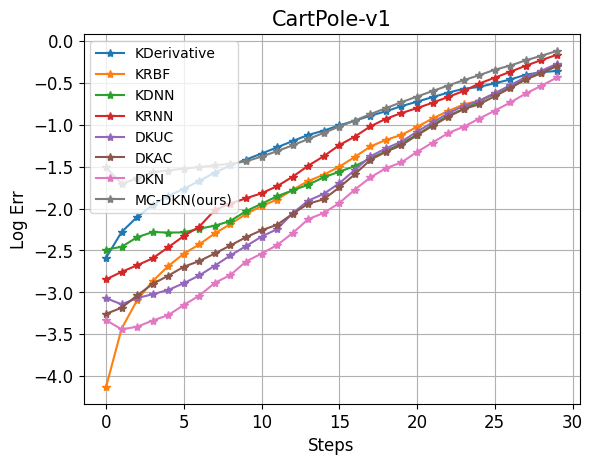

In [11]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',  "#1c1c1f"]
font = {'size'   : 12}

plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
# env_name = "DampingPendulum"
env_name = "CartPole-v1"
# env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "DoublePendulum"
# env_name = "LunarLanderContinuous-v2"
title = env_name
compare = "max"
# compare = "mean"
# for i in range(8):
for i in [0,1,2,3,4,5,6,7]:
# for i in [6,7]:
    index = i
    method = Methods[index]
    if i == 0:
        if env_name == "DoublePendulum" or env_name == "Franka" or env_name == "LunarLanderContinuous-v2":
            continue
    if i >= 2:
        file_path = "../Prediction_Results/Compare/"+env_name+"_"+method+"embed.npy"
    else:
        file_path = "../Prediction_Results/Compare/"+env_name+"_"+method+".npy"
    data = np.load(file_path)
    # print(data.shape)
    if compare.startswith("max"):
        plt.plot(np.log10(data[0]),'*-',color = colors[index],label=Method_names[i],linewidth=1.5)
    else:
        plt.plot(np.log10(data[2]),'*-',color = colors[index],label=method)
plt.legend(loc='upper left', fontsize=10)
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.grid()
plt.title(title,fontsize=15)
plt.savefig("../Prediction_Results/Prediction/"+env_name+"_"+compare+"_new1.png",dpi=300)

In [ ]:

# 配置参数
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',  "#1c1c1f"]
font = {'size': 12}
plt.rc('font', **font)

# 定义要展示的6个环境（对应2×3子图）
envs = [
    "DampingPendulum", 
    "Pendulum-v1", 
    "LunarLanderContinuous-v2", 
    "CartPole-v1", 
    "DoublePendulum",
    "Franka"
]
compare = "max"  # 或 "mean"
# 假设Methods和Method_names已提前定义
# Methods = [...]  # 方法名称列表
# Method_names = [...]  # 方法显示名称列表

# 创建2×3子图
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 调整画布大小使子图清晰
axes = axes.flatten()  # 转换为1维数组便于索引

# 循环绘制每个环境的子图
for env_idx, env_name in enumerate(envs):
    ax = axes[env_idx]  # 当前子图的轴对象
    # 循环绘制每个方法的曲线
    for i in [0, 1, 2, 3, 4, 5, 6, 7]:
        index = i
        method = Methods[index]
        print(env_name)
        # 跳过特定环境下的方法0（保持原逻辑）
        if i == 0:
            if env_name in ["DoublePendulum", "Franka", "LunarLanderContinuous-v2"]:
                continue
        
        # 加载数据（区分带embed和不带embed的文件）
        if i >= 2:
            file_path = f"../Prediction_Results/Compare/{env_name}_{method}embed.npy"
        else:
            file_path = f"../Prediction_Results/Compare/{env_name}_{method}.npy"
        data = np.load(file_path)
        print(method, data[0][14], data[1][14])
        # 绘制曲线（根据compare选择max或mean数据）
        if compare.startswith("max"):
            ax.plot(np.log10(data[0]), '*-', color=colors[index], 
                    label=Method_names[i] if env_idx == 0 else "",  # 只在第一个子图标记图例
                    linewidth=1.5, markersize=5)  # 调整标记大小避免拥挤
        else:
            ax.plot(np.log10(data[2]), '*-', color=colors[index], 
                    label=Method_names[i] if env_idx == 0 else "",
                    linewidth=1.5, markersize=5)
    
    # 设置子图属性
    ax.set_xlabel("Steps", fontsize=16) if env_idx != 4 else None
    ax.set_ylabel("Log Err", fontsize=16)
    ax.grid(linestyle='-.', alpha=0.7)  # 网格线半透明
    ax.set_title(env_name, fontsize=18, pad=10)  # 标题加边距
    if env_idx == 5:
        ax.set_ylim((-4, 0))
    ax.tick_params(axis='both', labelsize=14)  # 调整刻度字体大小

# 统一设置图例（放在画布底部，避免子图内拥挤）
handles, labels = axes[0].get_legend_handles_labels()  # 从第一个子图获取图例
fig.legend(handles, labels, loc='lower center', ncol=4,  # 4列布局
           bbox_to_anchor=(0.5, -0.02), fontsize=12)

# 调整子图间距，避免重叠
plt.tight_layout()
# 保存图片（预留底部空间放图例）
fig.savefig(f"../Prediction_Results/Prediction/summary_{compare}_new1.png", 
            dpi=300, bbox_inches='tight')  # bbox_inches确保图例完整保存
plt.close()

DampingPendulum
KoopmanDerivative 0.671697020117578 0.06466905866875093
DampingPendulum
KoopmanRBF 0.027094987102959066 0.006153405699107193
DampingPendulum
KNonlinear 0.013378006492087535 0.001779184460138483
DampingPendulum
KNonlinearRNN 0.022339203926835933 0.002676887515626016
DampingPendulum
KoopmanU 0.02648246129983786 0.0035664893778590426
DampingPendulum
KoopmanNonlinearA 0.010565886501156505 0.001449282867185256
DampingPendulum
KoopmanNonlinear 0.0024956025509089586 0.0009491448104660555
DampingPendulum
DKNGU 0.0268199675325168 0.004145648966225528
Pendulum-v1
KoopmanDerivative 0.9483135760267059 0.012497185480494112
Pendulum-v1
KoopmanRBF 2.4238623363884564 0.11945306164281656
Pendulum-v1
KNonlinear 0.15021296977187928 0.02392996560233653
Pendulum-v1
KNonlinearRNN 0.2911426632804297 0.07040126993636434
Pendulum-v1
KoopmanU 0.6417737053719479 0.030163838677347204
Pendulum-v1
KoopmanNonlinearA 0.5584292686153667 0.03958937040022699
Pendulum-v1
KoopmanNonlinear 0.063587025414891